![Remezova](https://user-images.githubusercontent.com/70770455/223753401-1bce72c5-632a-484e-8ed1-abbd74361da2.png)

**Abstract** \
I (@fruitourist) tried to train the Fully Convolutional Network (*ResNet101*) on *Gaofen Image Dataset* to gem one of the 15 classes -- *Irrigated Land*. I was able to achieve a median Pixel Accuracy of *0.703* and a median IoU of *0.523*.

![remezova_fcn_resnet101_ep8bs32lr1e-4](https://user-images.githubusercontent.com/70770455/223796203-037f466e-8ae7-4939-8757-a614518a7e0d.png)

**Examples of predictions** \
Top to bottom: *subimage*, *predicted subimage mask* and *true subimage mask*  \
![view_remezova_fcn_resnet101_ep8bs32lr1e-4](https://user-images.githubusercontent.com/70770455/223796209-25640518-9b99-458a-99d5-dcb5b0a32807.png)

# Import

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from os import listdir
from typing import Tuple, List, Dict, Generator, Any
from IPython.display import clear_output

# Dataset
**Gaofen Image Dataset**. Ref: https://x-ytong.github.io/project/GID.html

## Download

In [ ]:
%%capture
!gdown "https://drive.google.com/uc?id=1--fNMFRXmBRDQPwdFqh54Sx7_RNE6z4a&confirm=t" # download image_RGB.zip
!gdown "https://drive.google.com/uc?id=1-3y-bJK-QZapo3nwZEXdVLWDjkVO4AYN&confirm=t" # download label_15classes.zip

In [ ]:
%%capture
!unzip image_RGB.zip
!unzip label_15classes.zip

## Organization

In [ ]:
!mkdir dataset dataset/originals dataset/labeleds

In [ ]:
classes = {
    (0, 0, 0): (0, '__background__'),
    # (200, 0, 0): (1, 'industrial_land'),
    # (250, 0, 150): (2, 'urban_residential'),
    # (200, 150, 150): (3, 'rural_residential'),
    # (250, 150, 150): (4, 'traffic_land'),
    # (0, 200, 0): (5, 'paddy_field'),
    (150, 250, 0): (1, 'irrigated_land'),
    # (150, 200, 150): (7, 'dry_cropland'),
    # (200, 0, 200): (8, 'garden_plot'),
    # (150, 0, 250): (9, 'arbor_woodland'),
    # (150, 150, 250): (10, 'shrub_land'),
    # (250, 200, 0): (11, 'natural_grassland'),
    # (200, 200, 0): (12, 'artifical_grassland'),
    # (0, 0, 200): (13, 'river'),
    # (0, 150, 200): (14, 'lake'),
    # (0, 200, 250): (15, 'pond')
}

classes_by_id = dict()
for rgb, (id, name) in classes.items():
  classes_by_id[id] = (rgb, name)

In [ ]:
def get_subimages_generator(
    image: Image.Image,
    subimage_size: Tuple[int, int, int]
) -> Generator[Image.Image, None, None]:
  for r in range(image.size[1] // subimage_size[1]):
    for c in range(image.size[0] // subimage_size[0]):
      yield image.crop(box=(
              c * subimage_size[0],
              r * subimage_size[1],
              (c + 1) * subimage_size[0],
              (r + 1) * subimage_size[1]
          )
      )

In [ ]:
def save_dataset_subimages(classes_filter: Dict[Tuple[int, int, int], float]):

  for i, filename in enumerate(listdir('image_RGB/')):
      basename = filename[:filename.find('.tif')]
      
      image = Image.open(fp=f'image_RGB/{basename}.tif').crop(box=(16, 40, 7200 - 16, 6800 - 40))
      image_labeled = Image.open(fp=f'label_15classes/{basename}_label.tif').crop(box=(16, 40, 7200 - 16, 6800 - 40))
      subimages = get_subimages_generator(image=image, subimage_size=(224,224))
      subimages_labeleds = get_subimages_generator(image=image_labeled, subimage_size=(224,224))

      for si, subimage in enumerate(subimages):
        subimage_labeled = next(subimages_labeleds)
        
        # classes filter
        do_continue = False
        subimage_labeled_colors_dict = {rgb: count for count, rgb in subimage_labeled.getcolors()}
        for rgb, min_percent in classes_filter.items():
          if rgb not in subimage_labeled_colors_dict \
              or subimage_labeled_colors_dict[rgb] * 100 / 50176 < min_percent:
              # 50176 = subimage width * subimage height
            do_continue = True
            break
        if do_continue:
          continue

        subimage.save(fp=f'dataset/originals/i{i}si{si}.tif')
        subimage_labeled.save(fp=f'dataset/labeleds/i{i}si{si}_labeled.tif')

In [ ]:
save_dataset_subimages(
    classes_filter={
        (150, 250, 0): 5
    }
)

In [ ]:
!ls -lR dataset/originals/*.tif | wc -l

4166


## Support functions and class

In [ ]:
def get_dataset_subimage(dataset_subimage_id: str) -> Tuple[Image.Image, Image.Image]:

  subimage = Image.open(fp=f'dataset/originals/{dataset_subimage_id}.tif')
  subimage_labeled = Image.open(fp=f'dataset/labeleds/{dataset_subimage_id}_labeled.tif')

  return subimage, subimage_labeled

In [ ]:
def get_image_mask_from_labeled(
    image_labeled: Image.Image,
    classes: Dict[Tuple[int, int, int], Tuple[int, str]]
) -> np.ndarray:

  image_mask = np.zeros(shape=(len(classes),image_labeled.size[0],image_labeled.size[1]))

  image_labeled_ndarray = np.array(object=image_labeled)
  for r in np.arange(stop=image_labeled_ndarray.shape[0]):
    for c in np.arange(stop=image_labeled_ndarray.shape[1]):
      class_rgb = tuple(image_labeled_ndarray[r][c])
      class_value = classes.get(class_rgb)
      if class_value:
        image_mask[class_value[0]][r][c] = 1.0
      else:
        image_mask[0][r][c] = 1.0

  return image_mask

In [ ]:
def get_image_labeled_from_mask(
    image_mask: np.ndarray,
    classes_by_id: Dict[Tuple[int, int, int], Tuple[int, str]]
) -> Image.Image:

  image_labeled_ndarray = np.zeros(
      shape=(image_mask.shape[1],image_mask.shape[2],3),
      dtype=np.uint8
  )

  image_mask_hot = image_mask.argmax(axis=0)
  for r in np.arange(stop=image_mask_hot.shape[0]):
    for c in np.arange(stop=image_mask_hot.shape[1]):
      class_id = image_mask_hot[r][c]
      class_by_id_value = classes_by_id.get(class_id)
      image_labeled_ndarray[r][c] = np.array(object=class_by_id_value[0])
  
  image_labeled = Image.fromarray(obj=image_labeled_ndarray)
  
  return image_labeled

In [ ]:
def image_preprocess(image: Image.Image) -> torch.Tensor:
  return torchvision.transforms.ToTensor()(pic=image)

In [ ]:
def get_dataset_subimage_tensor(
    subimage: Image.Image,
    subimage_labeled: Image.Image,
    classes: Dict[Tuple[int, int, int], Tuple[int, str]],
    dtype: torch.FloatType = None,
) -> Tuple[torch.Tensor, torch.Tensor]:

  subimage_tensor = image_preprocess(image=subimage)
  subimage_mask_tensor = torch.tensor(
      data=get_image_mask_from_labeled(
          image_labeled=subimage_labeled,
          classes=classes
      ),
      dtype=dtype
  )

  return subimage_tensor, subimage_mask_tensor

In [ ]:
def get_dataset_subimages_id() -> List[str]:
  return [
      filename[:filename.find('.tif')]
      for filename in listdir(path='dataset/originals/')
  ]

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self,
      dataset_subimages_id: List[str],
      classes: Dict[Tuple[int, int, int], Tuple[int, str]],
  ):
    self.dataset_subimages_id = dataset_subimages_id
    self.classes = classes
  
  def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
    subimage = Image.open(fp=f'dataset/originals/{self.dataset_subimages_id[idx]}.tif')
    subimage_labeled = Image.open(fp=f'dataset/labeleds/{self.dataset_subimages_id[idx]}_labeled.tif')
    subimage_tensor, subimage_mask_tensor = get_dataset_subimage_tensor(
        subimage=subimage,
        subimage_labeled=subimage_labeled,
        classes=self.classes
    )
    return subimage_tensor, subimage_mask_tensor
  
  def __len__(self) -> int:
    return len(self.dataset_subimages_id)

## View

In [ ]:
subimage, subimage_labeled = get_dataset_subimage(dataset_subimage_id='i0si0')

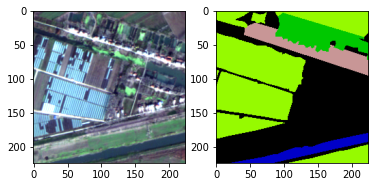

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(subimage)
ax[1].imshow(subimage_labeled)
plt.show()

In [ ]:
subimage_mask = get_image_mask_from_labeled(
    image_labeled=subimage_labeled,
    classes=classes
)

In [ ]:
subimage_labeled_from_mask = get_image_labeled_from_mask(
    image_mask=subimage_mask,
    classes_by_id=classes_by_id
)

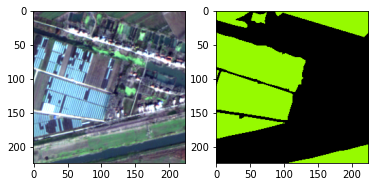

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(subimage)
ax[1].imshow(subimage_labeled_from_mask)
plt.show()

## Init
`batch_size = 32`

In [ ]:
train_dataset_subimages_id, test_dataset_subimages_id = train_test_split(get_dataset_subimages_id(), train_size=0.9)

In [ ]:
train_dataset = Dataset(
    dataset_subimages_id=train_dataset_subimages_id,
    classes=classes,
)
test_dataset = Dataset(
    dataset_subimages_id=test_dataset_subimages_id,
    classes=classes
)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=1
)

# Model
Fully Convolutional Network. Ref: https://arxiv.org/abs/1605.06211 \
**ResNet101**. Ref: https://arxiv.org/pdf/1512.03385.pdf

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Init

In [ ]:
%%capture
model = torchvision.models.segmentation.fcn_resnet101(
    num_classes=len(classes),
    weights_backbone=torchvision.models.ResNet101_Weights
).to(device=device)

## **AFTER TRAINING** Load

In [ ]:
%%capture
!gdown "https://drive.google.com/uc?id=17hu1Cj6WxXiQp89Quac-j6UUfjFwceeE&confirm=t"

In [ ]:
model.load_state_dict(
    state_dict=torch.load(
        f='drive/MyDrive/remezova_fcn_resnet101_ep8bs32lr1e-4.h5',
        map_location=device
    )
)

<All keys matched successfully>

## Predict

In [ ]:
def predict(
    image: Image.Image,
    model: torch.nn.Module,
    device: torch.DeviceObjType,
) -> Image.Image:

  image_tensor = image_preprocess(image=image)

  with torch.no_grad():
    output_image_mask = model(image_tensor.unsqueeze(0).to(device))['out'][0].cpu().numpy()

  predicted_image_labeled = get_image_labeled_from_mask(
      image_mask=output_image_mask,
      classes_by_id=classes_by_id
  )

  return predicted_image_labeled

### View

In [ ]:
predicted_image_labeled = predict(
    image=subimage,
    model=model,
    device=device
)

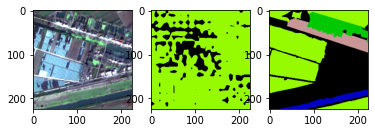

In [ ]:
fig, ax = plt.subplots(ncols=3)
ax[0].imshow(subimage)
ax[1].imshow(predicted_image_labeled)
ax[2].imshow(subimage_labeled)
plt.show()

## Metrics

In [ ]:
def metric_pixel_accuracy(
    y_pred: torch.Tensor,
    y_true: torch.Tensor
) -> float:

  y_pred_hot = y_pred >= 0.51

  correct_pixels = (y_pred_hot == y_true).count_nonzero()
  uncorrect_pixels = (y_pred_hot != y_true).count_nonzero()
  result = (correct_pixels / (correct_pixels + uncorrect_pixels)).item()

  return result

In [ ]:
def metric_iou(
    y_pred: torch.Tensor,
    y_true: torch.Tensor
) -> float:

  y_pred_hot = y_pred >= 0.51

  intersection = torch.logical_and(y_pred_hot, y_true).count_nonzero()
  union = torch.logical_or(y_pred_hot, y_true).count_nonzero()
  result = (intersection / union).item()

  return result

## Train

### Init

In [ ]:
def train(
    model: torch.nn.Module,
    device: torch.DeviceObjType,
    train_dataloader: torch.utils.data.DataLoader,
    loss_fn: Any,
    optim_fn: Any,
    epochs: int
) -> Dict[str, List[float]]:

  history_metrics = {
      'loss': list(),
      'pixel_accuracy': list(),
      'iou': list()
  }

  for e in range(1, epochs + 1):
    for b, data in enumerate(train_dataloader, start=1):
      subimage_tensor, subimage_mask_tensor = data
      
      if device.type == 'cuda':
        subimage_tensor = subimage_tensor.to(device)
        subimage_mask_tensor = subimage_mask_tensor.to(device)
      
      optim_fn.zero_grad()
      output = model(subimage_tensor)
      main_loss = loss_fn(output['out'], subimage_mask_tensor)
      aux_loss = loss_fn(output['aux'], subimage_mask_tensor)
      loss = main_loss + aux_loss
      loss.backward()
      optim_fn.step()

      loss_item = loss.item()
      pixel_accuracy = metric_pixel_accuracy(output['out'], subimage_mask_tensor)
      iou = metric_iou(output['out'], subimage_mask_tensor)

      history_metrics['loss'].append(loss_item)
      history_metrics['pixel_accuracy'].append(pixel_accuracy)
      history_metrics['iou'].append(iou)

      clear_output()
      print(
          'Epoch: {}. Batch: {}. Loss: {:.3f} | Pixel Accuracy: {:.3f} | IoU: {:.3f}'.format(
              e, b,
              loss, pixel_accuracy, iou
          )
      )

      # memory clear
      del subimage_tensor, subimage_mask_tensor, output, loss
      if device.type == 'cuda':
        torch.cuda.empty_cache()
  
  return history_metrics

### Train
`loss_fn = CrossEntropyLoss()` \
`optim_fn = AdamW(lr=1e-4)` \
`epochs = 8`

In [ ]:
history_metrics = train(
    model=model,
    device=device,
    train_dataloader=train_dataloader,
    loss_fn=torch.nn.CrossEntropyLoss(),
    optim_fn=torch.optim.AdamW(params=model.parameters(), lr=1e-4),
    epochs=8
)

### Research

In [ ]:
plt.plot(
    history_metrics['loss'], 'red',
    history_metrics['pixel_accuracy'], 'green',
    history_metrics['iou'], 'blue',
)
plt.title('History Metrics in Training\nep=8, bs=32, loss_fn=CrossEntopyLoss(), optim_fn=AdamW(lr=1e-4)')
plt.xlabel('Batch')
plt.ylabel('Value')
plt.legend(('Loss', 'Pixel Accuracy', 'IoU'))
plt.show()

### **USING GOOGLE COLAB MODULE** Save

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), 'remezova_fcn_resnet101_ep8bs32lr1e-4.h5')

In [ ]:
!mv remezova_fcn_resnet101_ep8bs32lr1e-4.h5 drive/MyDrive

## Test

### Init

In [ ]:
def test(
    model: torch.nn.Module,
    device: torch.DeviceObjType,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: Any,
) -> Dict[str, List[float]]:

  history_metrics = {
      'pixel_accuracy': list(),
      'iou': list()
  }

  for b, data in enumerate(test_dataloader, start=1):
    subimage_tensor, subimage_mask_tensor = data
    
    if device.type == 'cuda':
      subimage_tensor = subimage_tensor.to(device)
      subimage_mask_tensor = subimage_mask_tensor.to(device)
    
    with torch.no_grad():
      output = model(subimage_tensor)

    pixel_accuracy = metric_pixel_accuracy(output['out'], subimage_mask_tensor)
    iou = metric_iou(output['out'], subimage_mask_tensor)

    history_metrics['pixel_accuracy'].append(pixel_accuracy)
    history_metrics['iou'].append(iou)

    clear_output()
    print(
        'Batch: {}. median Pixel Accuracy: {:.3f} | median IoU: {:.3f}'.format(
            b,
            np.median(a=history_metrics['pixel_accuracy']),
            np.median(a=history_metrics['iou'])
        )
    )

    # memory clear
    del subimage_tensor, subimage_mask_tensor, output
    if device.type == 'cuda':
      torch.cuda.empty_cache()
  
  return history_metrics

### Test

In [ ]:
test_history_metrics = test(
    model=model,
    device=device,
    test_dataloader=test_dataloader,
    loss_fn=torch.nn.CrossEntropyLoss()
)

Batch: 417. median Pixel Accuracy: 0.703 | median IoU: 0.523


### View

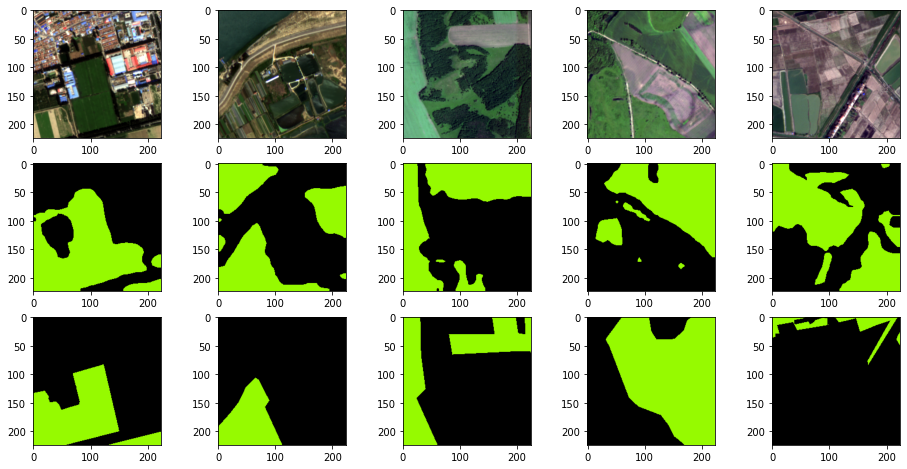

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(16,8))

for si, (subimage_tensor, subimage_mask_tensor) in enumerate(test_dataloader):
  subimage = torchvision.transforms.ToPILImage()(pic=subimage_tensor[0])
  subimage_labeled = get_image_labeled_from_mask(
      image_mask=subimage_mask_tensor[0].cpu().numpy(),
      classes_by_id=classes_by_id
  )
  predicted_subimage_labeled = predict(
      image=subimage,
      model=model,
      device=device
  )
  ax[0][si].imshow(subimage)
  ax[1][si].imshow(predicted_subimage_labeled)
  ax[2][si].imshow(subimage_labeled)
  
  if si == 5 - 1:
    break

plt.show()